In [ ]:
# import TensorFlow
import tensorflow as tf

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('CPU'))

2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
series = pd.read_excel('/content/sample_data/wind_mill.xlsx',index_col="DateTime")
series.head()

,Air_temperature (cel),Pressure (atm),Wind_speed (m/s),Wind_direction (deg),Power_generated_by_system (kW)
DateTime,,,,,
2007-01-01 00:00:00,10.926,0.979103,9.014,229,33688.1
2007-01-01 01:00:00,9.919,0.979566,9.428,232,37261.9
2007-01-01 02:00:00,8.567,0.979937,8.700,236,30502.9
2007-01-01 03:00:00,7.877,0.980053,8.481,247,28419.2
2007-01-01 04:00:00,7.259,0.979867,8.383,256,27370.3


In [ ]:
# Cleaning Data
series['Power_generated_by_system (kW)'].replace(0, np.nan, inplace=True)
series['Power_generated_by_system (kW)'].fillna(method='ffill', inplace=True)
print(series)

                     Air_temperature (cel)  Pressure (atm)  Wind_speed (m/s)  \
DateTime                                                                       
2007-01-01 00:00:00                 10.926        0.979103             9.014   
2007-01-01 01:00:00                  9.919        0.979566             9.428   
2007-01-01 02:00:00                  8.567        0.979937             8.700   
2007-01-01 03:00:00                  7.877        0.980053             8.481   
2007-01-01 04:00:00                  7.259        0.979867             8.383   
...                                    ...             ...               ...   
2012-12-31 19:00:00                  3.306        0.994371             2.089   
2012-12-31 20:00:00                  3.674        0.994060             1.785   
2012-12-31 21:00:00                  3.015        0.993726             1.590   
2012-12-31 22:00:00                 -0.317        0.993483             2.012   
2012-12-31 23:00:00                 -1.0

In [ ]:
# initialize variables
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 10
predict_values_exp = 24
lag_exp=24

In [ ]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [ ]:
# scale train and test data to [-1, 1]
from sklearn.preprocessing import MinMaxScaler
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [ ]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [ ]:
# fit an LSTM network to training data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [ ]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [ ]:
print(series.columns)

Index(['Air temperature (Â°C)', 'Pressure (atm)', 'Wind speed (m/s)',
       'Wind direction (deg)', 'Power generated by system (kW)'],
      dtype='object')


In [ ]:
# Drop all the features as we will not be having any in production
del series['Air_temperature (cel)']
del series['Pressure (atm)']
del series['Wind_speed (m/s)']
del series['Wind_direction (deg)']

In [ ]:
for i in range(0,10):
  series = series[:-1]
series.tail()

,Power_generated_by_system (kW)
DateTime,
2012-12-31 09:00:00,6110.57
2012-12-31 10:00:00,6251.34
2012-12-31 11:00:00,6899.17
2012-12-31 12:00:00,4514.49
2012-12-31 13:00:00,1561.25


In [ ]:
# create a differenced series
from pandas import Series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [ ]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [ ]:
# Print the raw and differenced values
print("Raw values:", raw_values)
print("Differenced values:", diff_values)

Raw values: [[33688.1 ]
 [37261.9 ]
 [30502.9 ]
 ...
 [ 6899.17]
 [ 4514.49]
 [ 1561.25]]
Differenced values: 0          [3573.800000000003]
1                    [-6759.0]
2        [-2083.7000000000007]
3        [-1048.9000000000015]
4        [-1564.3999999999978]
                 ...          
52544     [308.46000000000004]
52545     [140.77000000000044]
52546      [647.8299999999999]
52547    [-2384.6800000000003]
52548               [-2953.24]
Length: 52549, dtype: object


In [ ]:
# frame a sequence as a supervised learning problem
from pandas import DataFrame
from pandas import concat
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [ ]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [ ]:
# Print the supervised values
print("Supervised values:", supervised_values)

Supervised values: [[0 0 0 ... 0 0 array([3573.8])]
 [array([3573.8]) 0 0 ... 0 0 array([-6759.])]
 [array([-6759.]) array([3573.8]) 0 ... 0 0 array([-2083.7])]
 ...
 [array([140.77]) array([308.46]) array([-663.24]) ... array([-4245.2])
  array([4179.4]) array([647.83])]
 [array([647.83]) array([140.77]) array([308.46]) ... array([-4627.3])
  array([-4245.2]) array([-2384.68])]
 [array([-2384.68]) array([647.83]) array([140.77]) ... array([-7407.7])
  array([-4627.3]) array([-2953.24])]]


In [ ]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [ ]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

52525/52525 [==============================] - 121s 2ms/step - loss: 0.0132


In [ ]:
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
test_pred = list()

# Classify power level using CNN
def classify_power_level(prediction, low_threshold, high_threshold):
    if prediction < low_threshold:
        return 'low'
    elif prediction >= high_threshold:
        return 'high'
    else:
        return 'mid'

# Set your low and high thresholds
low_threshold = 15000
high_threshold = 30000

# Display Hour, Predicted, Expected, and Classified Power Level
expectations = np.array([])
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)  # make one-step forecast
    test_pred = np.array([yhat] + list(test_pred))  # Convert to numpy array for concatenation
    if i + 1 < len(test_scaled):
        end_idx = min(len(test_scaled[i+1]), len(test_pred))
        test_scaled[i + 1] = np.concatenate((test_pred[:end_idx], test_scaled[i + 1, end_idx:]), axis=0)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    predictions = np.append(predictions, yhat)  # Use np.append instead
    expected = raw_values[len(train) + i + 1]
    expectations = np.append(expectations, expected)  # Add expected value to the array

1/1 [==============================] - 0s 22ms/step


In [ ]:
# Print the results separately
for i in range(len(predictions)):
    classified_power_level = classify_power_level(predictions[i], low_threshold, high_threshold)
    print('Hour=%d, Predicted=%f, Expected=%f, Classified=%s' % (i + 1, predictions[i], expectations[i], classified_power_level))

Hour=1, Predicted=27137.839927, Expected=20005.800000, Classified=mid
Hour=2, Predicted=20603.973719, Expected=19870.600000, Classified=mid
Hour=3, Predicted=20033.384454, Expected=23296.700000, Classified=mid
Hour=4, Predicted=21174.780584, Expected=36275.400000, Classified=mid
Hour=5, Predicted=33825.002809, Expected=41119.700000, Classified=high
Hour=6, Predicted=38744.740593, Expected=45831.200000, Classified=high
Hour=7, Predicted=44716.358787, Expected=38451.600000, Classified=high
Hour=8, Predicted=39342.733652, Expected=38107.700000, Classified=high
Hour=9, Predicted=39049.110602, Expected=36325.100000, Classified=high
Hour=10, Predicted=35859.245418, Expected=37641.300000, Classified=high
Hour=11, Predicted=37129.761332, Expected=36876.500000, Classified=high
Hour=12, Predicted=36775.006753, Expected=35723.600000, Classified=high
Hour=13, Predicted=35477.927398, Expected=28221.500000, Classified=high
Hour=14, Predicted=26995.580785, Expected=22650.000000, Classified=mid
Hour=1

In [ ]:
# Convert predictions and expectations to numpy arrays
expectations = np.array(expectations)
predictions = np.array(predictions)

# Calculate MAPE
mape = np.mean(np.abs((expectations - predictions) / expectations)) * 100
print("Mean Absolute Percent Error: ", mape)

Mean Absolute Percent Error:  32.6718756815996


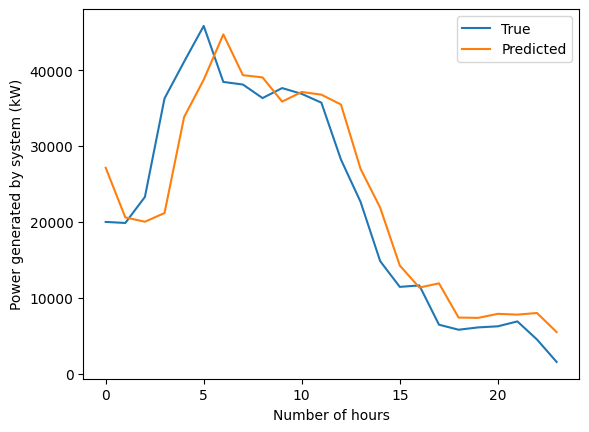

In [ ]:
from matplotlib import pyplot
pyplot.plot(raw_values[-predict_values_exp:], label="True")
pyplot.plot(predictions, label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()

In [ ]:
from keras.models import save_model

# Save the model
lstm_model.save('lstm_model.h5')

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Define the function to normalize input features
def normalize_features(features):
    # Assuming the original range for each feature was 0 to 100
    return features / 100.0

# Define the function to denormalize the prediction
def denormalize_prediction(prediction):
    # Assuming the denormalization range for power is 0 to 6000 kW
    return abs(prediction) * 6000.0

# Load the trained LSTM model
lstm_model = load_model('/content/lstm_model.h5')

# Take user input for the four features
air_temperature = float(input("Enter air temperature (°C): "))
pressure = float(input("Enter pressure (atm): "))
wind_speed = float(input("Enter wind speed (m/s): "))
wind_direction = float(input("Enter wind direction (deg): "))

# Normalize the input features
input_features = np.array([[air_temperature, pressure, wind_speed, wind_direction]])
normalized_features = normalize_features(input_features)

# Expand the input features to match the expected shape (batch_size, 1, 24)
normalized_features_expanded = np.zeros((normalized_features.shape[0], 1, 24))
normalized_features_expanded[:, :, :4] = normalized_features

# Make a prediction using the LSTM model
prediction = lstm_model.predict(normalized_features_expanded)

# Denormalize the prediction
predicted_power = denormalize_prediction(prediction[0][0])

# Display the predicted power output
print("Predicted power generated by the system:", predicted_power, "kW")